In [1]:
import numpy as np
import numpyro
import jax
import asterion as ast
from jax import random
from numpyro import handlers
from asterion.models import GlitchModel

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
key = random.PRNGKey(11)

n = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
truths = {
    '_nu_max': 2300.0,
    'delta_nu': 110.0,
    'epsilon': 1.3,
    'log_a_he': -2.1,
    'log_b_he': -6.1,
    'log_tau_he': -3.06,
    'phi_he': 1.0,
    'log_a_cz': 5.5,
    'log_tau_cz': -2.6,
    'phi_cz': -0.9,
}

key, k1, k2 = random.split(key, 3)

nu_max_err = 25.
nu_max = np.array(truths['_nu_max'] + nu_max_err * random.normal(k1))

delta_nu_err = 0.1
delta_nu = np.array(truths['delta_nu'] + delta_nu_err * random.normal(k2))

In [3]:
model = GlitchModel(n, (nu_max, nu_max_err), (delta_nu, delta_nu_err))

In [4]:
true_model = handlers.condition(model, data=truths)

In [5]:
true_model = handlers.substitute(true_model, {
    'kernel_length': 5.0,
    'kernel_var': 0.1*delta_nu,
})

In [6]:
num_samples = 50
key, k = random.split(key)

predictive = numpyro.infer.Predictive(true_model, num_samples=num_samples)
true_pred = predictive(k, pred=True)

Plot samples from the "true posterior". This shows the GP at work, showing the prior on background functions. We can randomly highlight one and take that as the "truth" for this example.

In [7]:
import matplotlib.pyplot as plt

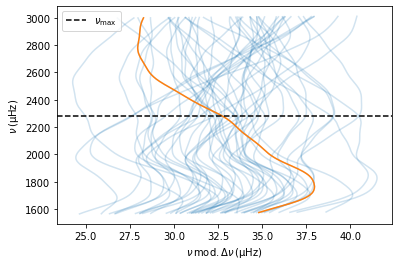

In [8]:
key, k = random.split(key)
i = random.randint(k, (), 0, num_samples)

nu_mod = (true_pred['nu_pred'] - model.n_pred*delta_nu) % delta_nu

fig, ax = plt.subplots()

ax.plot(nu_mod.T, true_pred['nu_pred'].T, color='C0', alpha=0.2)
ax.plot(nu_mod[i], true_pred['nu_pred'][i], color='C1')

ax.axhline(nu_max, linestyle='--', color='k', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [9]:
# Let's add some more to the truths
truths['nu'] = true_pred['nu_obs'][i]
truths['he_amplitude'] = true_pred['he_amplitude'][i]

In [10]:
key, k = random.split(key)
nu_err = 0.01
nu = truths['nu'] + nu_err * random.normal(k)

In [11]:
import matplotlib.pyplot as plt

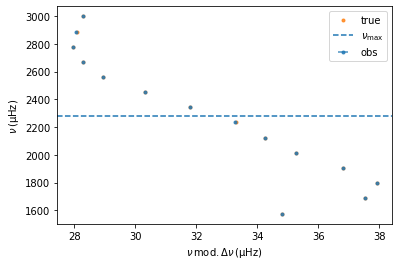

In [12]:
nu_mod = truths['nu'] % delta_nu
nu_mod_obs = nu % delta_nu

fig, ax = plt.subplots()

ax.errorbar(nu_mod_obs, nu, xerr=nu_err, fmt='.', label='obs', alpha=0.8)
ax.plot(nu_mod, truths['nu'], '.', label='true', alpha=0.8)

ax.axhline(nu_max, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [13]:
from asterion.inference import Inference

In [14]:
infer = Inference(model, nu=truths['nu'], seed=40)

/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:106: UserWarning: Parameter 'phi_he' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC. Ignore this message if using nested sampling (default behaviour).
  warnings.warn(f"Parameter \'{value['name']}\' has " +
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:106: UserWarning: Parameter 'phi_cz' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC. Ignore this message if using nested sampling (default behaviour).
  warnings.warn(f"Parameter \'{value['name']}\' has " +


In [15]:
infer.prior_predictive()

In [16]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

In [17]:
data.prior_predictive.nu.median(dim=('draw', 'chain'))

<xarray.DataArray 'nu' (n: 14)>
array([1583.08527755, 1693.6624932 , 1803.76139191, 1913.11452525,
       2023.24464085, 2132.83555323, 2243.29359117, 2353.53348089,
       2463.42755446, 2572.56518772, 2682.53883682, 2792.98644857,
       2903.34620648, 3013.65910955])
Coordinates:
  * n        (n) int64 13 14 15 16 17 18 19 20 21 22 23 24 25 26

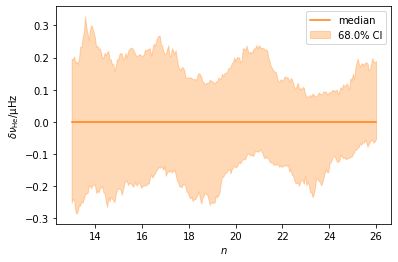

In [18]:
ast.plot_glitch(data, group='prior');

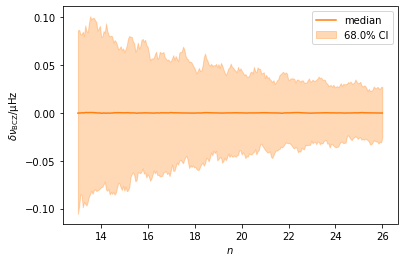

In [19]:
ast.plot_glitch(data, group='prior', kind='CZ');

In [20]:
infer.sample()

Running nested sampling using the 'multi_ellipsoid' sampler with 100 live points and 100000 maximum samples...
Completed in 12.3 seconds.


In [21]:
infer.posterior_predictive()

In [22]:
data = infer.get_data()
data

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

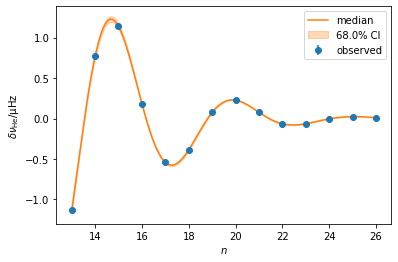

In [23]:
ast.plot_glitch(data);

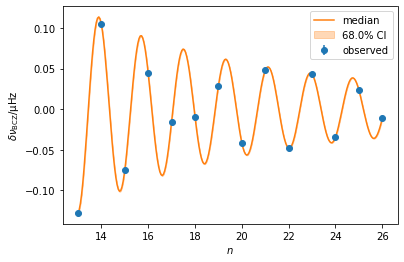

In [24]:
ast.plot_glitch(data, kind='CZ');

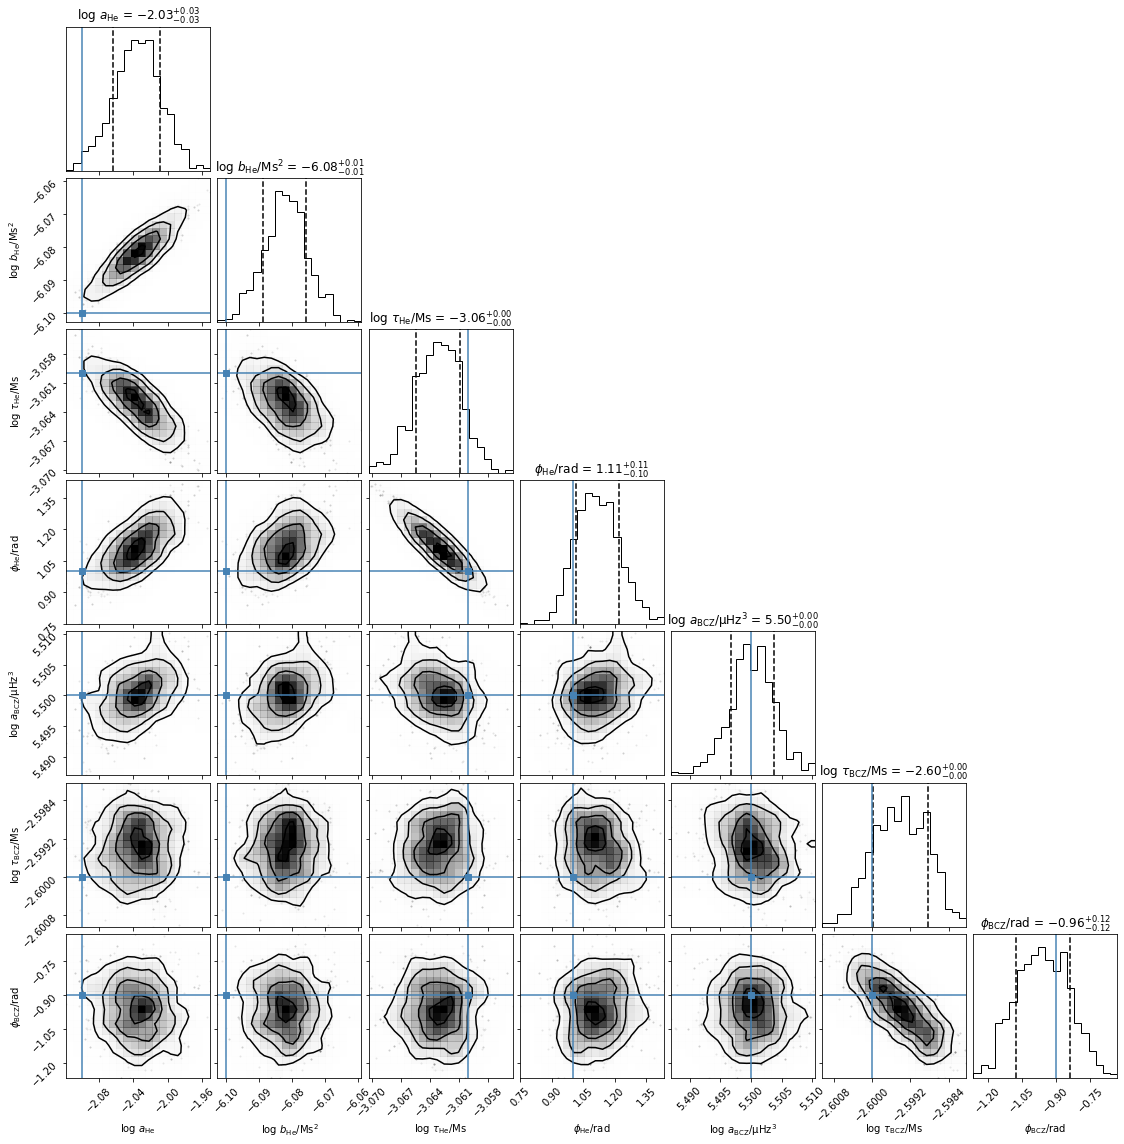

In [25]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names, truths=truths);

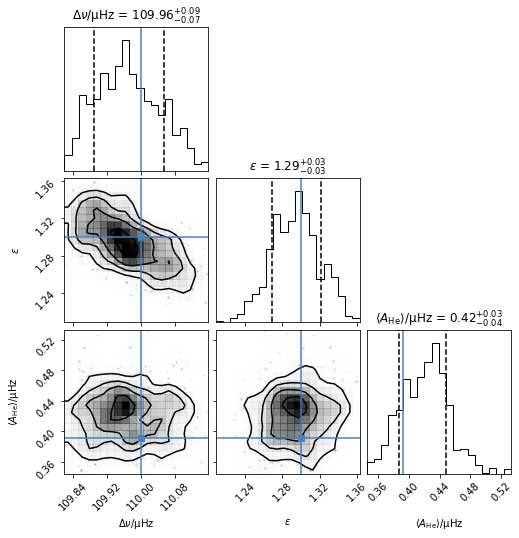

In [26]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_amplitude'], truths=truths);

In [36]:
import h5py

In [39]:
file = h5py.File('../tests/test_data.hdf5', 'w')

In [40]:
t = file.create_group('truths')
for key, value in truths.items():
    t[key] = value

In [41]:
o = file.create_group('observed')
o['nu'] = nu
o['nu_err'] = nu_err

In [42]:
p = file.create_group('model')
p['n'] = n
p['nu_max'] = (nu_max, nu_max_err)
p['delta_nu'] = (delta_nu, delta_nu_err)

In [43]:
file.close()

In [34]:
file = h5py.File('../tests/test_data.hdf5')